# Compare analyzers on MNIST - for all output neurons

This notebook shows how saliency maps are computed for various methods on the MNIST dataset. It is based on the [method comparison on MNIST](mnist_method_comparison.ipynb) notebook, but extends it by looking at the analysis of all output neurons!

We will first train a simple 3-layer MLP and then apply different methods. In the end we allow for a qualitive assesment by plotting the analysis as a grid.

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter("ignore")

In [2]:
%matplotlib inline

import imp
import os

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
import utils as eutils
import utils.mnist as mnistutils

## Data
Load the dataset and keep some images from the test set for the analysis.

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(
    x_train, input_range
)

# Preprocess data
data = (
    preprocess(x_train),
    y_train,
    preprocess(x_test),
    y_test,
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

## Model
The next part trains and evaluates a CNN.

In [4]:
# Create & train model
input_shape = (28, 28, 1)

model = keras.models.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

scores = mnistutils.train_model(model, data, batch_size=128, epochs=10)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 34s 567us/sample - loss: 0.1409 - accuracy: 0.9562
Epoch 2/10
60000/60000 [==============================] - 37s 623us/sample - loss: 0.0357 - accuracy: 0.9892
Epoch 3/10
60000/60000 [==============================] - 39s 657us/sample - loss: 0.0208 - accuracy: 0.9933
Epoch 4/10
60000/60000 [==============================] - 42s 697us/sample - loss: 0.0132 - accuracy: 0.9956
Epoch 5/10
60000/60000 [==============================] - 43s 725us/sample - loss: 0.0090 - accuracy: 0.9972
Epoch 6/10
60000/60000 [==============================] - 41s 680us/sample - loss: 0.0060 - accuracy: 0.9982
Epoch 7/10
60000/60000 [==============================] - 41s 680us/sample - loss: 0.0086 - accuracy: 0.9970
Epoch 8/10
60000/60000 [==============================] - 42s 703us/sample - loss: 0.0063 - accuracy: 0.9980
Epoch 9/10
60000/60000 [==============================] - 42s 698us/sample - loss: 0.0028 - accuracy: 0.9

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [5]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255


noise_scale = (input_range[1] - input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
# fmt: off
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN            TITLE
    # Show input
    ("input",               {},                         input_postprocessing,   "Input"),
    # Function
    ("gradient",            {"postprocess": "abs"},     mnistutils.graymap,     "Gradient"),
    ("smoothgrad",
                            {"noise_scale": noise_scale, 
                             "postprocess": "square"},  mnistutils.graymap,     "SmoothGrad"),
    # Signal
    ("deconvnet",           {},                         mnistutils.bk_proj,     "Deconvnet"),
    ("guided_backprop",     {},                         mnistutils.bk_proj,     "Guided Backprop"),
    # Interaction
    ("deep_taylor.bounded", {"low": input_range[0], 
                             "high": input_range[1]},   mnistutils.heatmap,     "DeepTaylor"),
    ("input_t_gradient",    {},                         mnistutils.heatmap,     "Input * Gradient"),
    ("integrated_gradients",{"reference_inputs": ri},   mnistutils.heatmap,     "Integrated Gradients"),
    ("lrp.z",               {},                         mnistutils.heatmap,     "LRP-Z"),
    ("lrp.epsilon",         {"epsilon": 1},             mnistutils.heatmap,     "LRP-Epsilon"),
]
# fmt: on

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [6]:
# Create model without trailing softmax
model_wo_softmax = innvestigate.model_wo_softmax(model)

# Create analyzers.
analyzers = [
    innvestigate.create_analyzer(
        method[0], model_wo_softmax, neuron_selection_mode="index", **method[1]
    )
    for method in methods
]

Now we analyze each image with the different analyzers on all output neurons:

--------------------------------------------------------------------------------
Image nr. 0: 


<Figure size 640x480 with 0 Axes>

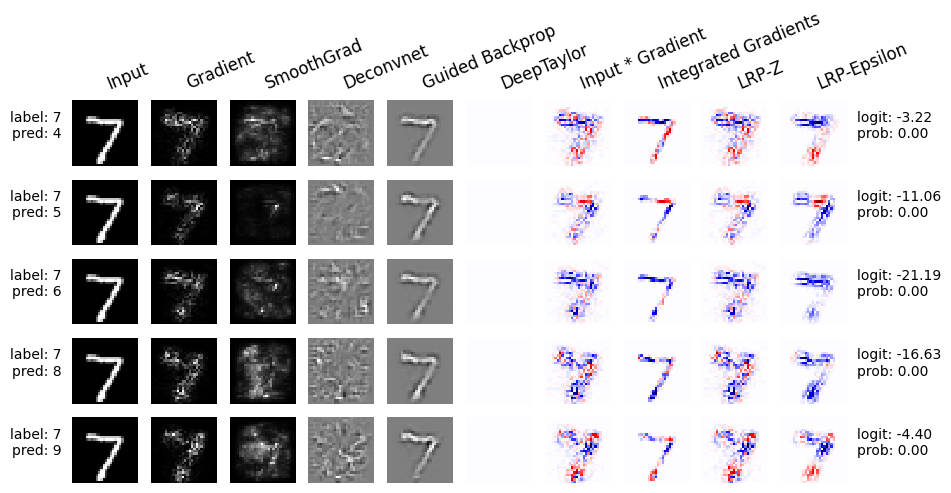

--------------------------------------------------------------------------------
Image nr. 1: 


<Figure size 640x480 with 0 Axes>

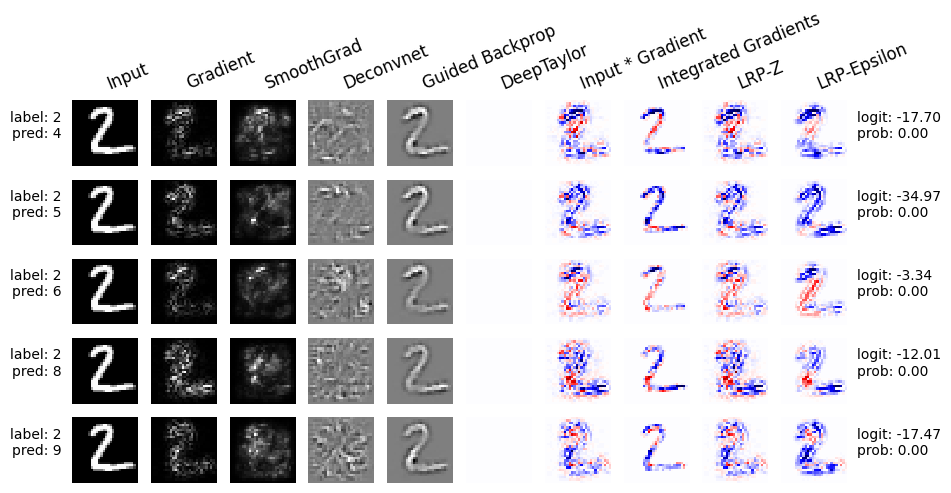

--------------------------------------------------------------------------------
Image nr. 2: 


<Figure size 640x480 with 0 Axes>

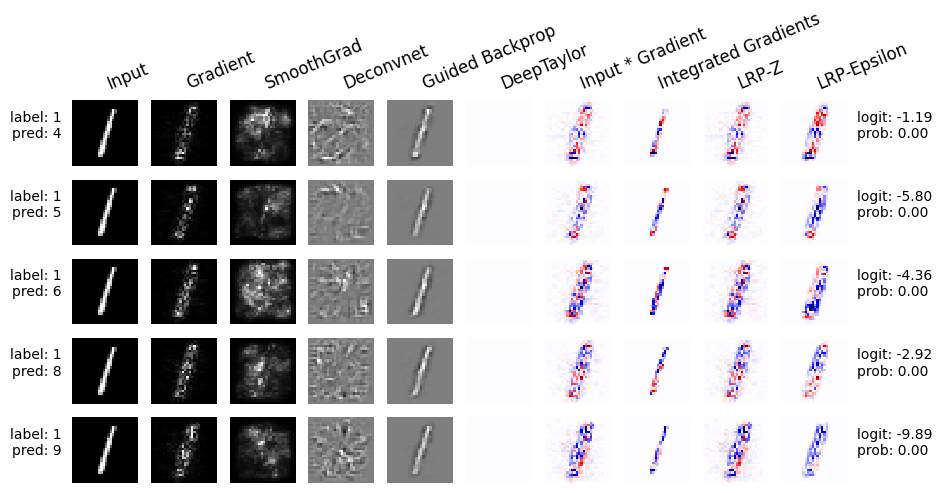

--------------------------------------------------------------------------------
Image nr. 3: 


<Figure size 640x480 with 0 Axes>

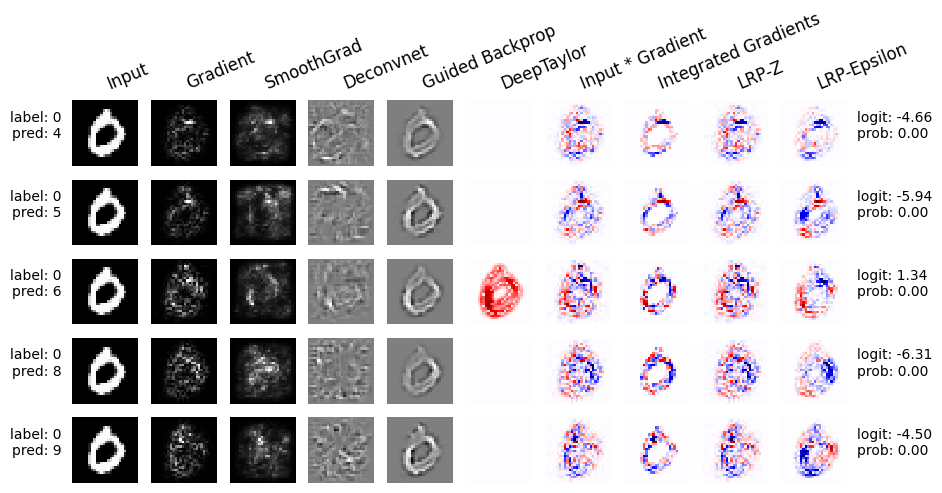

--------------------------------------------------------------------------------
Image nr. 4: 


<Figure size 640x480 with 0 Axes>

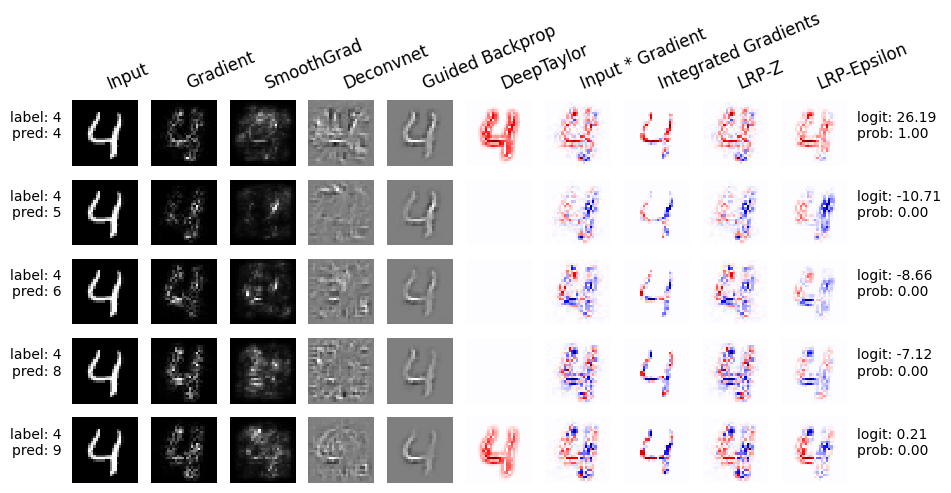

--------------------------------------------------------------------------------
Image nr. 5: 


<Figure size 640x480 with 0 Axes>

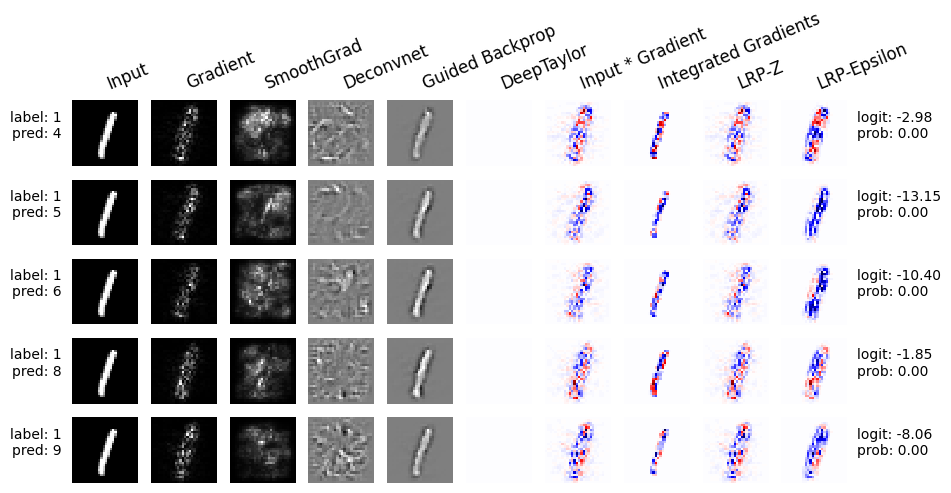

--------------------------------------------------------------------------------
Image nr. 6: 


<Figure size 640x480 with 0 Axes>

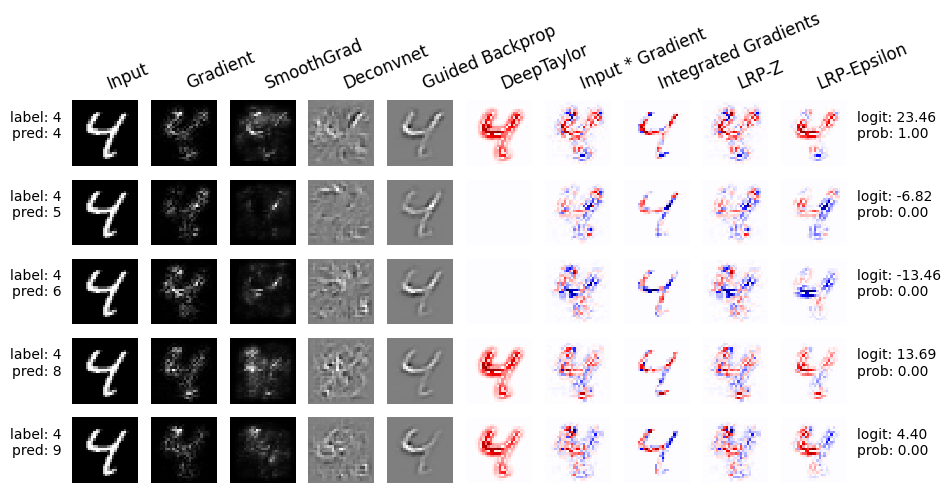

--------------------------------------------------------------------------------
Image nr. 7: 


<Figure size 640x480 with 0 Axes>

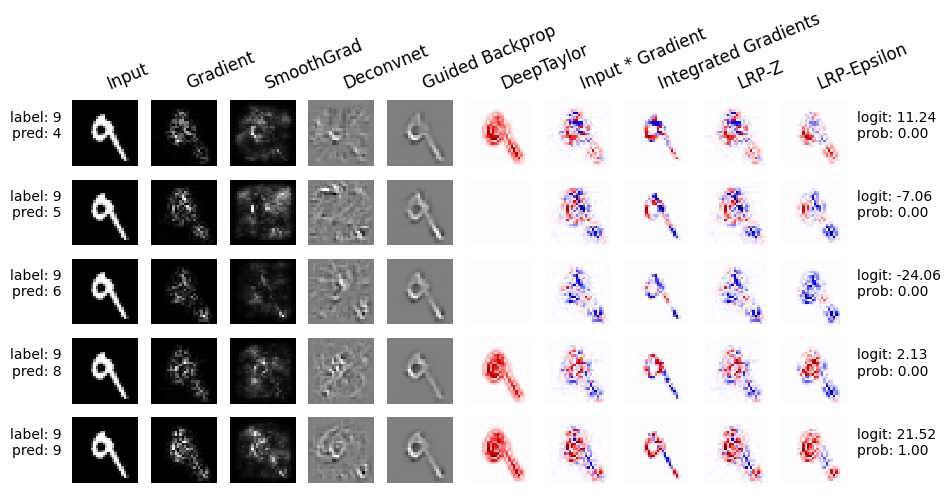

--------------------------------------------------------------------------------
Image nr. 8: 


<Figure size 640x480 with 0 Axes>

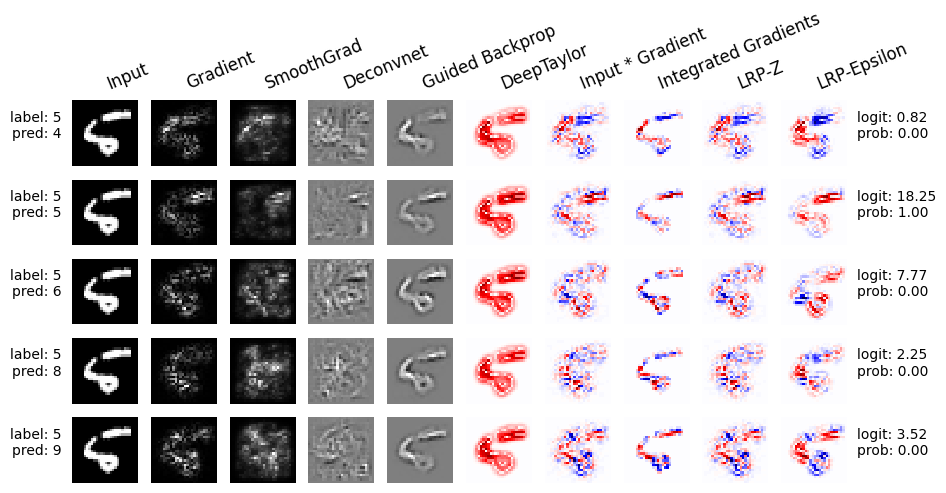

--------------------------------------------------------------------------------
Image nr. 9: 


<Figure size 640x480 with 0 Axes>

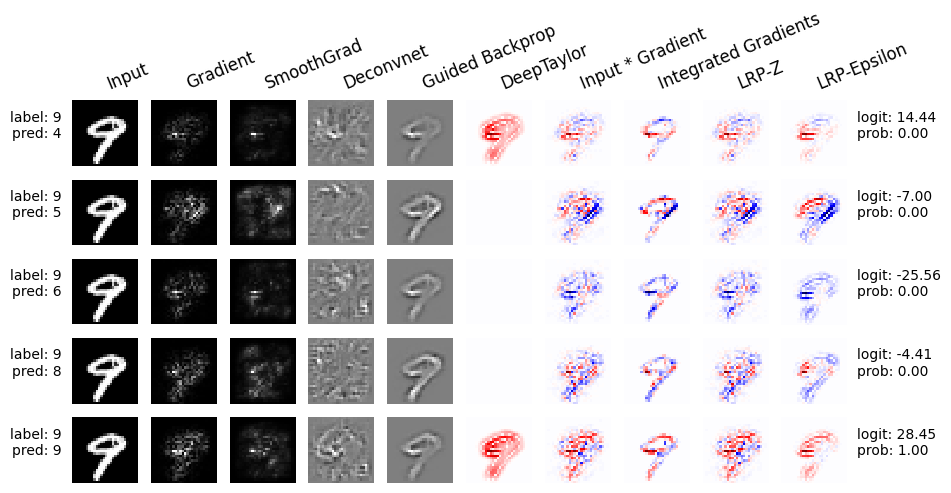

In [7]:
n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

for image_nr, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([5, len(analyzers), 28, 28, 3])
    text = []

    for ii, output_neuron in enumerate([4, 5, 6, 8, 9]):  # range(num_classes):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(
            (
                "%s" % label_to_class_name[y],  # ground truth label
                "%.2f" % presm[output_neuron],  # pre-softmax logits
                "%.2f" % prob[output_neuron],  # probabilistic softmax output
                "%s" % label_to_class_name[output_neuron],
            )
        )

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-" * 80)
    print(f"Image nr. {image_nr}: ")
    # Prepare the grid as rectengular list
    grid = [
        [analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])
    ]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    row_labels_left = [
        (f"label: {label[i]}", f"pred: {pred[i]}") for i in range(len(label))
    ]
    row_labels_right = [
        (f"logit: {presm[i]}", f"prob: {prob[i]}") for i in range(len(label))
    ]
    col_labels = ["".join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
    if file_name is not None:
        file_name = (
            ".".join(file_name.split(".")[:-1])
            + ("_%i" % output_neuron)
            + file_name.split(".")[-1]
        )
    eutils.plot_image_grid(
        grid, row_labels_left, row_labels_right, col_labels, file_name=file_name
    )

Each column shows the visualized results for different analyzers and each row shows the analyses w.r.t. to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).

If you are curious about how *iNNvestigate* performs on ImageNet model, have a look here: [Comparing methods on ImageNet](imagenet_method_comparison.ipynb) and [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb)